In [1]:
import itertools
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn import svm
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from scipy.stats import rankdata
%matplotlib inline

dataset = datasets.load_iris()
# =================   ==============
# Toy dataset :
# Classes                          3
# Samples per class               50
# Samples total                  150
# Dimensionality                   4
# Features            real, positive
# =================   ==============
dataset = datasets.load_iris()

X, y = dataset.data,dataset.target
# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

n_classes = np.unique(y_train).shape[0]
n_pairs = (n_classes)*(n_classes-1)

# classify and calculate scores
# classifier = OneVsOneClassifier(GaussianNB())
# y_score = classifier.fit(X_train,y_train).decision_function(X_test)
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# OneVsRest Classifier
# classifier = OneVsRestClassifier(MultinomialNB())
# y_score = classifier.fit(X_train,y_train).predict_proba(X_test)

# =================   ==============
# Frequentist method of estimating AUC
# =================   ==============
overall_auc = 0
indiv_m1_m2 = np.zeros(n_pairs) #individual m1*m2
indiv_count = np.zeros(n_pairs)
indiv_auc = np.zeros(n_pairs)
names = {}
l = 0
for i,j in itertools.product(range(n_classes),range(n_classes)):
    if (i==j):
        continue
    name = 'A ('+ dataset.target_names[i]+'|'+dataset.target_names[j] +')'
    i_score = y_score[y_test==i][:,i]
    j_score = y_score[y_test==j][:,i]
    alldata = np.concatenate((i_score , j_score))
    ranked = rankdata(alldata)
    m1 = len(i_score)
    m2 = len(j_score)
    i_rank = ranked[:m1]
    j_rank = ranked[m1:]
    s = np.sum(i_rank,axis=0)
    count = s - m1*(m1+1)/2.0
    indiv_m1_m2[l] = m1*m2
    indiv_count[l] = count
    indiv_auc[l] = float(count)/(m1*m2)
    overall_auc += indiv_auc[l]
    names[l] = name
    l += 1
overall_auc = overall_auc/(n_classes*(n_classes-1))
sample = 20000
burnin = 5000

/Users/cindyzhou/anaconda2/lib/python2.7/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 4.796777
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7


100%|██████████| 20000/20000 [00:02<00:00, 6746.65it/s]


Optimization terminated successfully.
         Current function value: 5.455513
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9


100%|██████████| 20000/20000 [00:03<00:00, 5640.79it/s]


Optimization terminated successfully.
         Current function value: 4.509257
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5


100%|██████████| 20000/20000 [00:02<00:00, 6747.37it/s]


Optimization terminated successfully.
         Current function value: 4.703316
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5


100%|██████████| 20000/20000 [00:03<00:00, 5797.28it/s]


Optimization terminated successfully.
         Current function value: 5.107423
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


100%|██████████| 20000/20000 [00:02<00:00, 6882.19it/s]


Optimization terminated successfully.
         Current function value: 4.776526
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


100%|██████████| 20000/20000 [00:03<00:00, 6097.87it/s]


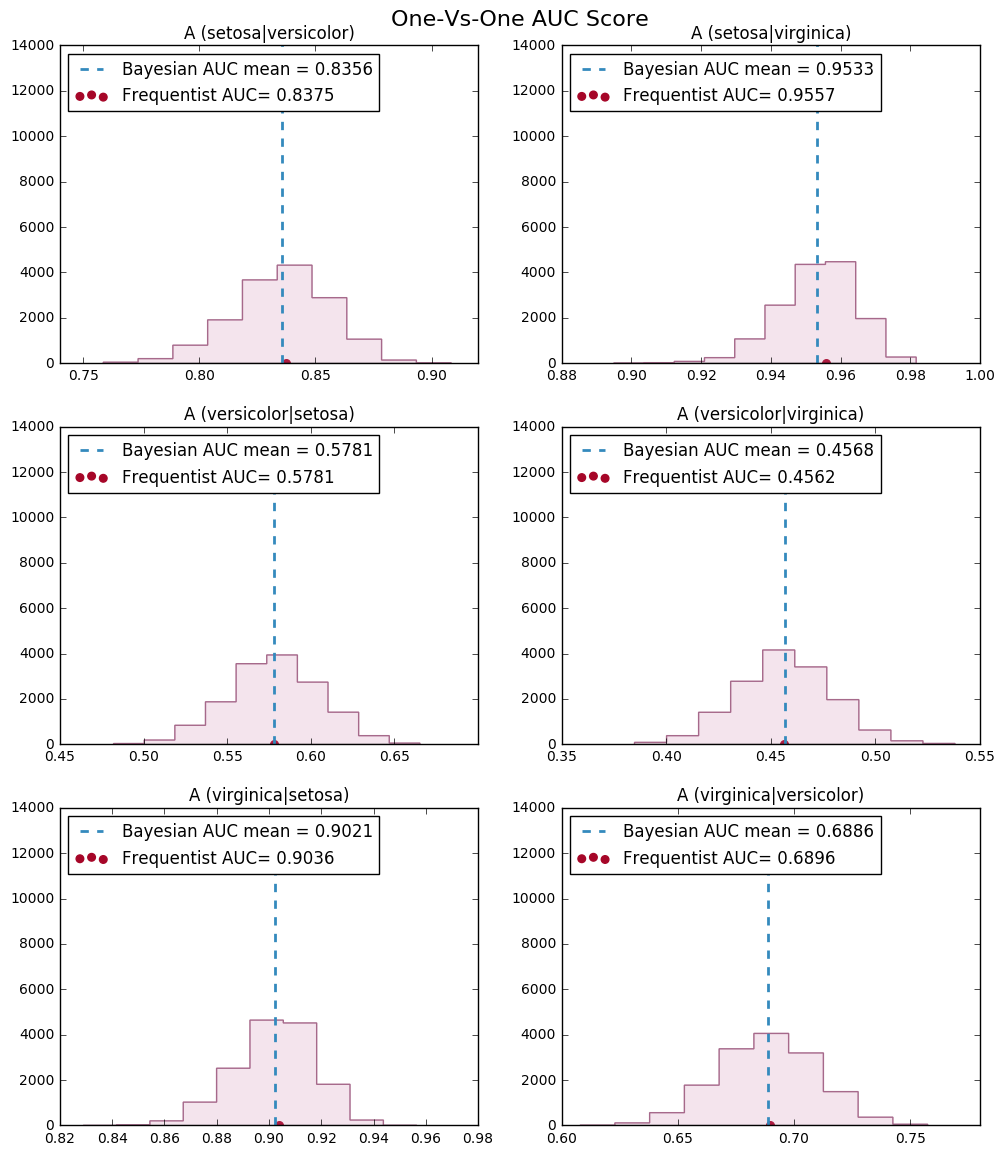

In [2]:
# =================   ==============
# Bayesian pooled model 
# =================   ==============
indiv_traces = {}
for i in range(n_pairs):
    with pm.Model() as model:
        name = names[i]

        p = pm.Beta('p',alpha=1,beta=1) # prior prediction 
        n = pm.Binomial('n',n=indiv_m1_m2[i],p=p,observed=indiv_count[i])

        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(sample, step, start=start, progressbar=True)
        indiv_traces[i] = trace

colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

figure = plt.figure(figsize=((n_classes-1)*5, (n_classes)*4))

for i in range(n_pairs):
    ax = figure.add_subplot(n_classes,(n_classes-1),i+1)
    ax.set_ylim(0,sample*0.7)
    auc_trace = indiv_traces[i].get_values('p')[burnin:]
    auc_mean = auc_trace.mean()
    _ = ax.hist(auc_trace,alpha=.9,
             histtype='step', color=colors[5], 
             label='')
    _hist = ax.hist(auc_trace,alpha=.2,
             histtype='stepfilled', color=colors[5])
    _ = ax.vlines(auc_mean, ymin=0.1, ymax=sample*0.7,
                  label='Bayesian AUC mean = {0:0.4f}'.format(auc_mean),
           linestyles='--', color=colors[0], linewidths=2)
    _ = ax.scatter(indiv_auc[i], 2, label='Frequentist AUC= {0:0.4f}'.format(indiv_auc[i])
                   ,color=colors[1], marker='o',s= 30)
    _ = ax.legend(loc='upper left')
    _ = ax.set_title(names[i])

figure.subplots_adjust(left=.04, right=.96, bottom=.05, top=.95)
figure.suptitle('One-Vs-One AUC Score\n', fontsize=16)
plt.show()

Optimization terminated successfully.
         Current function value: 29.458918
         Iterations: 27
         Function evaluations: 29
         Gradient evaluations: 29


100%|██████████| 20000/20000 [00:10<00:00, 1879.78it/s]


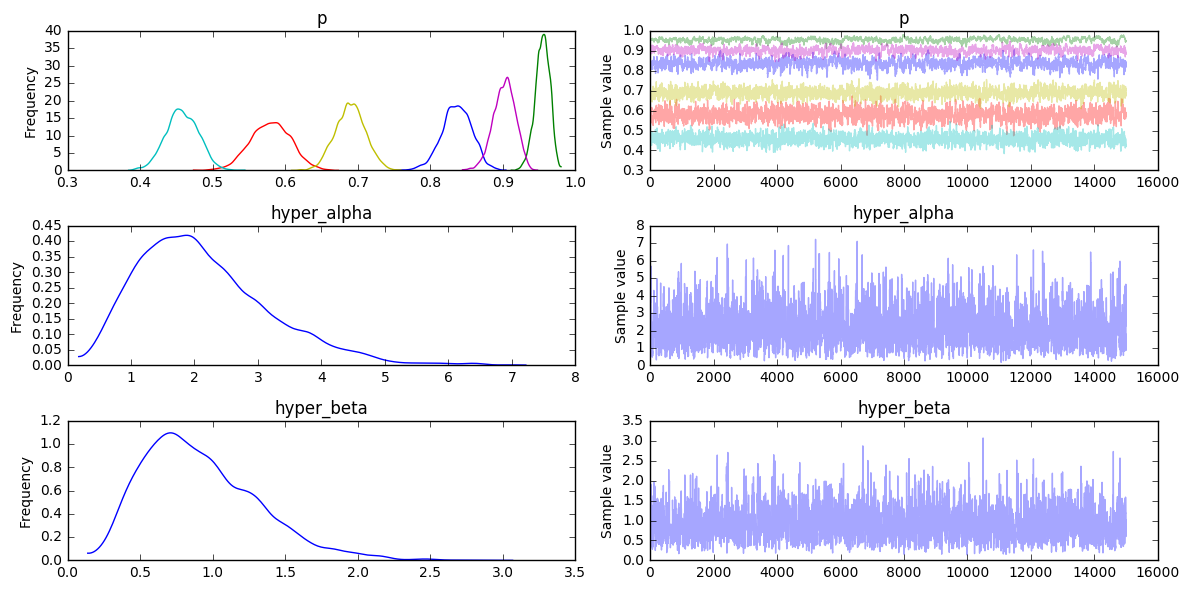

In [3]:
# =================   ==============
# Bayesian partial pooled model 
# =================   ==============

with pm.Model() as model:

    hyper_alpha = pm.Exponential('hyper_alpha',lam=1)
    hyper_beta = pm.Exponential('hyper_beta',lam=1)
    
    p = pm.Beta('p',alpha = hyper_alpha, beta = hyper_beta, shape = n_pairs)
    n = pm.Binomial('n',n=indiv_m1_m2,p=p,observed=indiv_count,shape = n_pairs)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    hierarchical_trace = pm.sample(sample, step, progressbar=True)

_ = pm.traceplot(hierarchical_trace[burnin:], ['p','hyper_alpha','hyper_beta'])

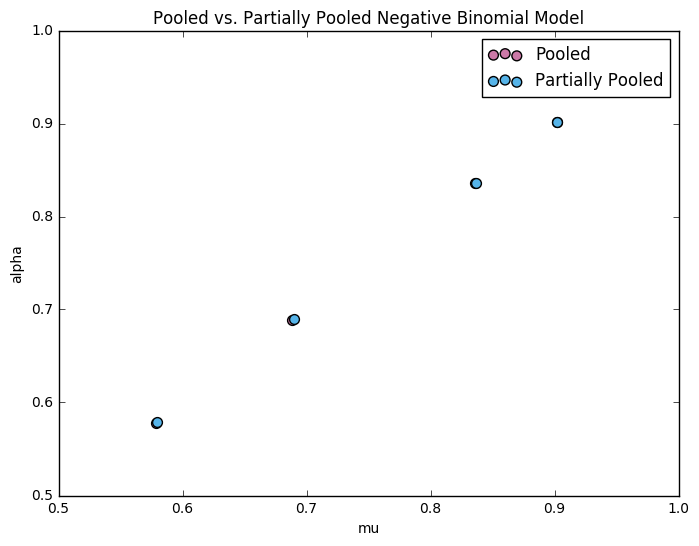

In [5]:
# =================   ==============
# Pooled VS Partial Pooled 
# =================   ==============
indv_p = np.array([v.get_values('p')[burnin:].mean(axis=0) for k, v in indiv_traces.items()])
hier_p = hierarchical_trace.get_values('p')[burnin:].mean(axis=0)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='mu', ylabel='alpha', 
                     title='Pooled vs. Partially Pooled Negative Binomial Model', 
                     xlim=(0.5,1), ylim=(0.5,1))

ax.scatter(indv_p, indv_p, c=colors[5], s=50, label = 'Pooled', zorder=3)
ax.scatter(hier_p, hier_p, c=colors[6], s=50, label = 'Partially Pooled', zorder=4)
for i in range(len(indv_p)):  
    ax.arrow(indv_p[i], indv_p[i], hier_p[i] - indv_p[i], hier_p[i] - indv_p[i], 
            fc="grey", ec="grey", length_includes_head=True, alpha=.5, width = 0.0001 ,head_width=0)

_ = ax.legend()
plt.show()

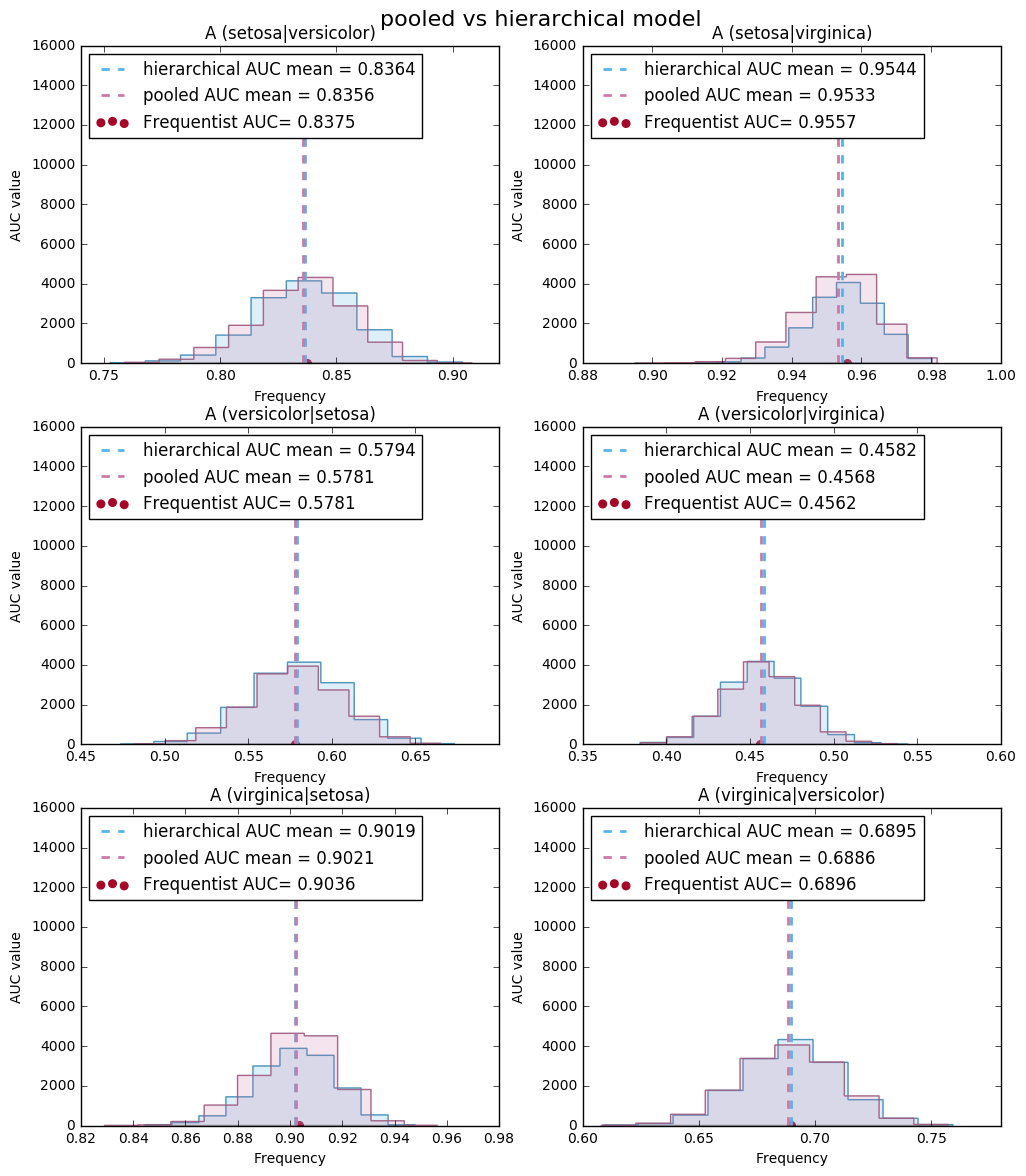

In [6]:
# =================   ==============
figure = plt.figure(figsize=((n_classes-1)*5, (n_classes)*4))
n_pair = n_classes*(n_classes-1)
for i in range(n_pairs):
    ax = figure.add_subplot(n_classes,(n_classes-1),i+1)
    ax.set_ylim(0,sample*0.8)
    indv_trace = indiv_traces[i].get_values('p')[burnin:]
    indv_mean = indv_trace.mean()
    hier_trace = hierarchical_trace['p'][:,i][burnin:]
    hier_mean = hier_trace.mean()
    
    _ = ax.hist(hier_trace,alpha=.9,histtype='step', color=colors[6])
    _hist = ax.hist(hier_trace,alpha=.2,
             histtype='stepfilled', color=colors[6])
    _ = ax.vlines(hier_mean, ymin=0.1, ymax=sample*0.7,
                  label='hierarchical AUC mean = {0:0.4f}'.format(hier_mean),
           linestyles='--', color=colors[6], linewidths=2)
    _ = ax.hist(indv_trace,alpha=.9,histtype='step', color=colors[5])
    _hist = ax.hist(indv_trace,alpha=.2,histtype='stepfilled', color=colors[5])
    _ = ax.vlines(indv_mean, ymin=0.1, ymax=sample*0.7,
                  label='pooled AUC mean = {0:0.4f}'.format(indv_mean),
           linestyles='--', color=colors[5], linewidths=2)
    _ = ax.scatter(indiv_auc[i], 2, label='Frequentist AUC= {0:0.4f}'.format(indiv_auc[i])
                   ,color=colors[1], marker='o',s= 30)
    _ = ax.set_ylabel('AUC value')
    _ = ax.set_xlabel('Frequency')
    _ = ax.legend(loc='upper left')
    _ = ax.set_title(names[i])

figure.subplots_adjust(left=.04, right=.96, bottom=.05, top=.95)
figure.suptitle('pooled vs hierarchical model\n', fontsize=16)
plt.show()

In [184]:
indv_trace

array([ 0.73484129,  0.73484129,  0.73484129, ...,  0.74695864,
        0.71914227,  0.71914227])

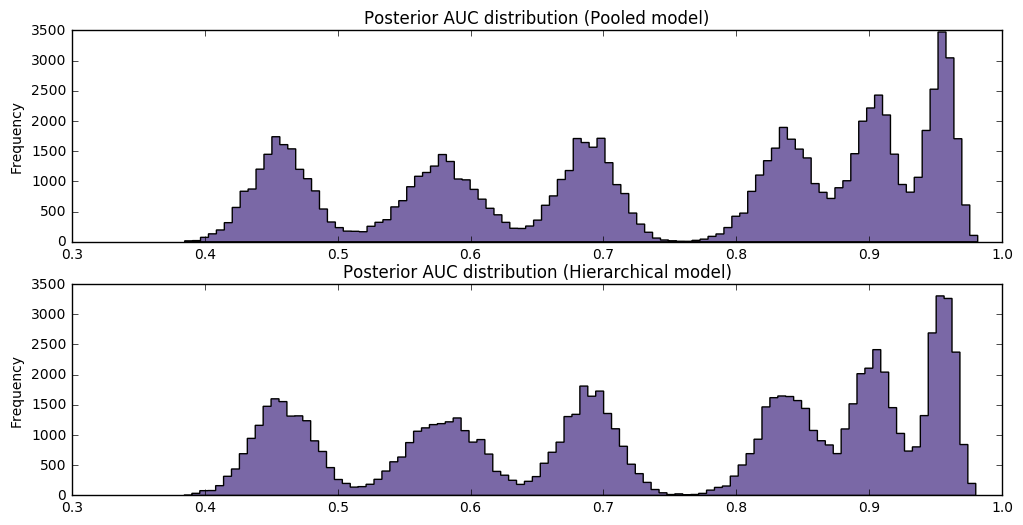

In [7]:
# =================   ==============
combined_auc = np.concatenate([v.get_values('p')[burnin:] for k, v in indiv_traces.items()])
figure = plt.figure(figsize=(12,6))
ax = figure.add_subplot(211)

_ = ax.hist(combined_auc,bins=100,histtype='stepfilled', color=colors[2])   
_ = ax.set_ylabel('Frequency')
_ = ax.set_title('Posterior AUC distribution (Pooled model)')

combined_auc2 = np.concatenate(hierarchical_trace.get_values('p')[burnin:])

ax = figure.add_subplot(212)

_ = ax.hist(combined_auc2,bins=100,histtype='stepfilled', color=colors[2])   
_ = ax.set_ylabel('Frequency')
_ = ax.set_title('Posterior AUC distribution (Hierarchical model)')
plt.show()